<a href="https://colab.research.google.com/github/mishraabhyuday/Text_Mercato_Task/blob/main/Text_Mercato_Assgn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Name: Abhyuday Mishra
2. Email: mishraabhyuday.mishra@gmail.com

In [ ]:
## Import all important libraries
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import ResNet50, imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization, Input, \
                                    LSTM, Embedding, Input, TimeDistributed, Bidirectional, Activation, RepeatVector, Concatenate
from keras.preprocessing.sequence import pad_sequences


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import cv2
import os

In [ ]:

## Link a colab with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Text_Mercato_Assgn/Assgn

/content/drive/MyDrive/Text_Mercato_Assgn/Assgn


In [ ]:
pwd

'/content/drive/MyDrive/Text_Mercato_Assgn/Assgn'

In [ ]:
## Read the file
df = pd.read_excel('dataset_1.xlsx')
df.head()

,Title,Description,Material,Pattern,Neckline,Image_Path
0,Peach Poly Crepe jumpsuit,This stylish foil print kurta from janasya is ...,Crepe,Printed,Round Neck,/images/pic_0.jpg
1,Light Brown Bias Yoke Checks Top,This check pattern top by Work Label is crafte...,Cotton,Checks,Round Neck,/images/pic_1.jpg
2,Off White Geometric Straight Cotton Dobby Top ...,"Featuring elegant printed details, this off wh...",Viscose,Checks,Round Neck,/images/pic_2.jpg
3,Blue Me Away Cape Top,Add an extra dose of style to your casual ward...,Polyester,Solid/Plain,V-Neck,/images/pic_3.jpg
4,Yellow On A High Gown,Yellow polyester georgette maxi dress. Polyest...,Polyester,Solid/Plain,V-Neck,/images/pic_4.jpg


In [ ]:
df.shape

(500, 6)

In [ ]:

## Store the image path and description in list 
Img_path = list(df['Image_Path'])
Img_Description = list(df["Description"])

In [ ]:
#Img_Description

**Image** **Preprocessing**
1.   Use ResNet to get image features
2.   Resize and reshape the image to required amt and convert BRG format to RGB
3.   Build a dictionary of image features using image path as key 
   
   

In [ ]:
imagePath = []
for i in Img_path:
  ip = "." + i
  imagePath.append(ip)

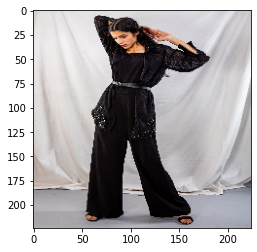

In [ ]:
img = cv2.imread('./images/pic_101.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
plt.imshow(img)

In [ ]:
ResNet = ResNet50(include_top=True)

In [ ]:
## Apply ResNet model on all images selecting the 2nd from last layer
last = ResNet.layers[-2].output
modell = Model(inputs = ResNet.input,outputs = last)
modell.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
## Lets predict using ResNet model and add it in a dictionary
images_features = {}
count = 0
for i in imagePath:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = modell.predict(img).reshape(2048,)    
    images_features[i] = pred

**Text Preprocessing** 


1.   Create a dictionary of description having image path as key
2.   Change BGR to RGB
3.   Add starting as well as ending words to the description



In [ ]:
#Create a dictionary of image path to description
dataa = {}
for i, j in zip(imagePath, Img_Description):
  dataa[i] = j

In [ ]:

## Preprocess the description
def preprocessed(txt):
    modified = txt.lower()
    ## Add start and end element in description
    modified = 'seqstart ' + modified + ' seqend'   
    return modified


In [ ]:
## Apply the preprocessing on our dict
for k,v in dataa.items():
      dataa[k] = preprocessed(v)


In [ ]:

## After preprocessing
dataa['./images/pic_82.jpg']

'seqstart a timeless and versatile take on evening dressing, this dark blue gown features a plunging neckline and thigh high-slit skirt which adds a feminine touch to the silhouette. team this chic style with heels, a clutch and delicate jewellery. seqend'

**Vocabuary of dictionary(basis:The frequency of words)**

In [ ]:

## Create a Vocabulary or Vocabulary of dictionary
count_words = {}
for k,v in dataa.items():
  
  for word in v.split():
    if word not in count_words:

      count_words[word] = 0

    else:
      count_words[word] += 1

In [ ]:
#for key in count_words:
 # count_words[key] +=1

In [ ]:
len(count_words)

1934

In [ ]:
## total number of red word present in our description
count_words['red']

17

In [ ]:
#Encoding our dictionary
## concert a caption dict in the interger words i.e., machine understandable form
## Key as imagePath and description converted to integers
for k, v in dataa.items():
   
  encoded = []
  for word in v.split():  
    encoded.append(count_words[word])

  dataa[k] = encoded

*** The Generator Function ***

*Splitting each word and setting next word to repredicted as our output.*

In [ ]:
#find the longest description

max_len = 0
for k, v in dataa.items():

  if len(v) > max_len:
    max_len = len(v)

In [ ]:
max_len

88

In [ ]:
#generator function
## Generate a X, y_in and y_out taking photo dict(i.e., contain ResNet prediction) and caption dict(i.e., contain description in integer)
VOCAB_SIZE = len(count_words)

def generator(photo, caption):
    
  X = []
  y_in = []
  y_out = []
  
  for k, v in caption.items():
    
    for i in range(1, len(v)):
      X.append(photo[k])         ## Appending image featurees to X var

      in_seq= [v[:i]]            ## splitting the description in a sequence i.e., 0-1, 0-1-2, 0-1-2-3, ........... 
      out_seq = v[i]             ## Next word

      ## use pad sequence to convert the variable length to max_len i.e., 88
      in_seq = pad_sequences(in_seq, maxlen=max_len, padding='post', truncating='post')[0]
      out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

      y_in.append(in_seq)
      y_out.append(out_seq)
          
  return X, y_in, y_out

In [ ]:
X, y_in, y_out = generator(images_features, dataa)

In [ ]:

## convert them  in array
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

In [ ]:
## shapes
X.shape, y_in.shape, y_out.shape

((18477, 2048), (18477, 88), (18477, 1934))

*** Building Sequential Model***

1.   Image Model
2.   Language Model




In [ ]:
embedding_size = 128
max_len = max_len
vocab_size = len(count_words)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 88, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 88, 128)           247552    
_________________________________________________________________
lstm (LSTM)                  (None, 88, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 88, 128)           32896     
Total params: 674,688
Traina

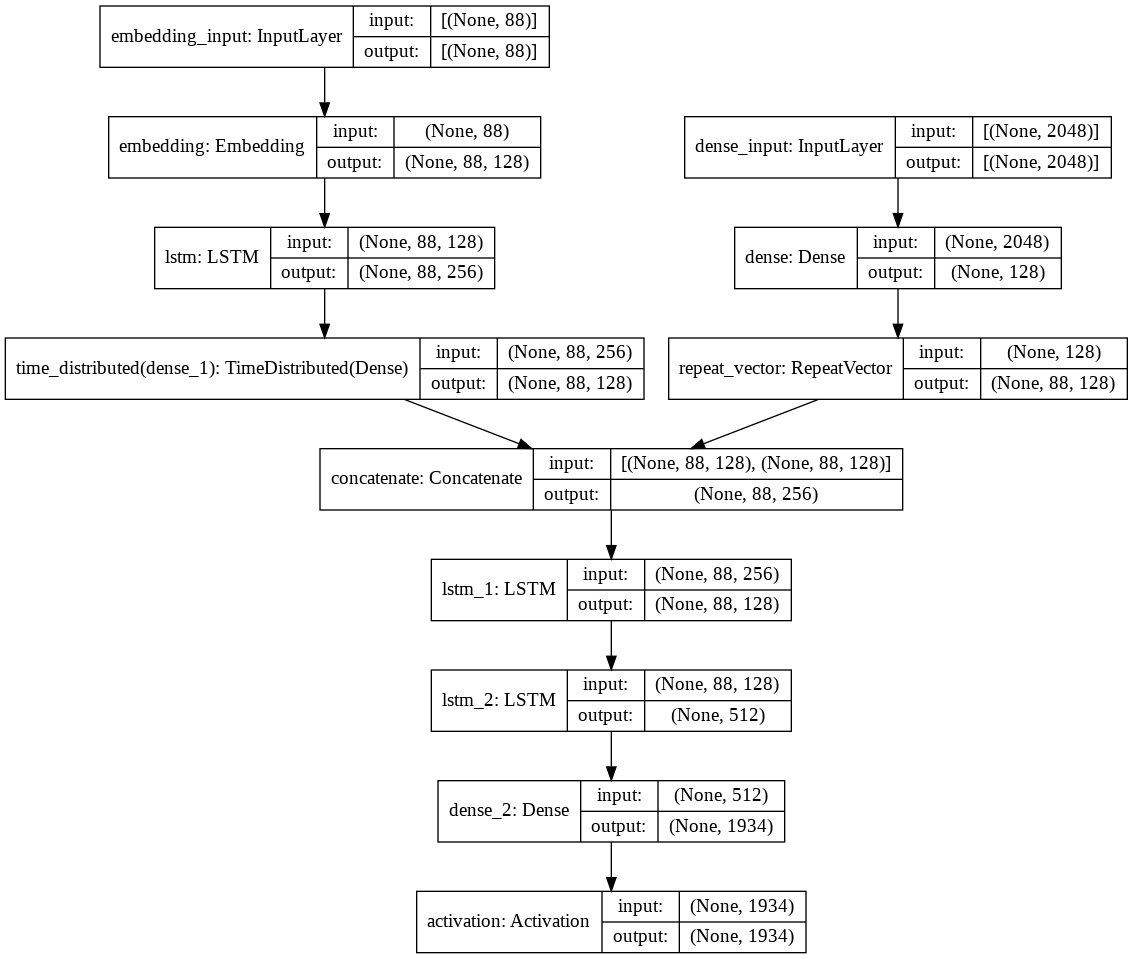

In [ ]:
## plot the model
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
#Training the model on 100 Epochs
model.fit([X, y_in], y_out, batch_size=512, epochs=100)

Epoch 1/100
37/37 [==============================] - 10s 187ms/step - loss: 5.0280 - accuracy: 0.0367
Epoch 2/100
37/37 [==============================] - 7s 190ms/step - loss: 4.2988 - accuracy: 0.0441
Epoch 3/100
37/37 [==============================] - 7s 191ms/step - loss: 4.2921 - accuracy: 0.0454
Epoch 4/100
37/37 [==============================] - 7s 194ms/step - loss: 4.2793 - accuracy: 0.0494
Epoch 5/100
37/37 [==============================] - 7s 197ms/step - loss: 4.2494 - accuracy: 0.0617
Epoch 6/100
37/37 [==============================] - 7s 198ms/step - loss: 4.2481 - accuracy: 0.0567
Epoch 7/100
37/37 [==============================] - 7s 198ms/step - loss: 4.2040 - accuracy: 0.0558
Epoch 8/100
37/37 [==============================] - 7s 198ms/step - loss: 4.1858 - accuracy: 0.0611
Epoch 9/100
37/37 [==============================] - 7s 196ms/step - loss: 4.1452 - accuracy: 0.0673
Epoch 10/100
37/37 [==============================] - 7s 195ms/step - loss: 4.1510 - accur

In [ ]:
## Inverse the dictionary
inv_dict = {v:k for k, v in count_words.items()}

In [ ]:
## save the model
model.save('image_desc.h5')

*** Testing the model **

In [ ]:

## function to convert the image in machine readable format
def getImage(x):
  
  test_img = cv2.imread(x)
  test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

  test_img = cv2.resize(test_img, (224,224))

  test_img = np.reshape(test_img, (1,224,224,3))
  
  return test_img

In [ ]:
test_feature = modell.predict(getImage('test_img.jpg')).reshape(1,2048)

In [ ]:
text_inp = ['seqstart']

count = 0
desc = ''
while count < 25:
  count += 1

  encoded = []
  for i in text_inp:
    encoded.append(count_words[i])

  encoded = [encoded]

  encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_len)


  ## Returns a highest probability word
  prediction = np.argmax(model.predict([test_feature, encoded]))     
 
  sampled_word = inv_dict[prediction]

  desc = desc + ' ' + sampled_word
      
  if sampled_word == 'seqend':
    break

  text_inp.append(sampled_word)

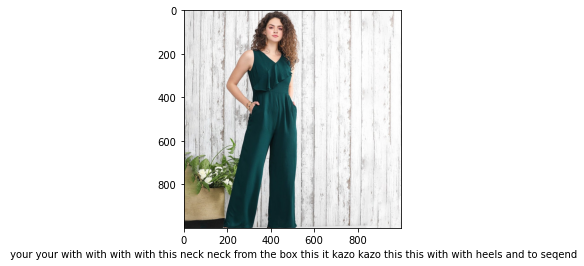

In [ ]:
imag = cv2.imread('test_img.jpg')
imag = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
plt.imshow(imag)
plt.xlabel(desc);

In [ ]:

## function to convert the image in machine readable format
def getImage_train(x):
  
  test_img_path = imagePath[x]

  test_img = cv2.imread(test_img_path)
  test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

  test_img = cv2.resize(test_img, (224,224))

  test_img = np.reshape(test_img, (1,224,224,3))
  
  return test_img

*** On the train images dataset ***

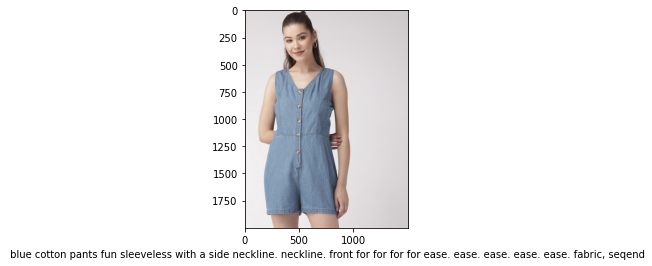

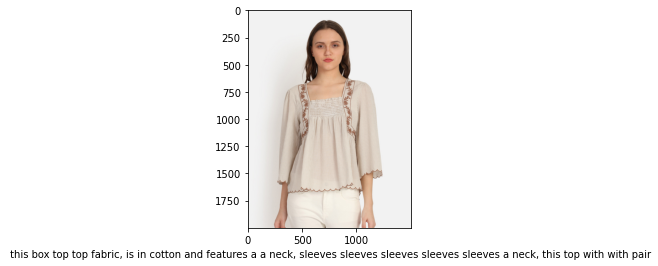

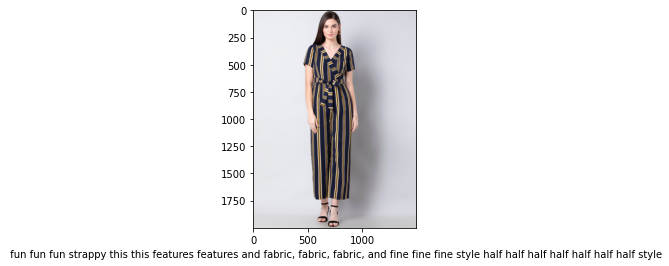

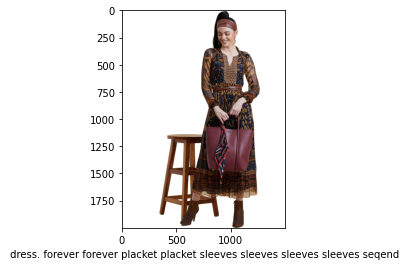

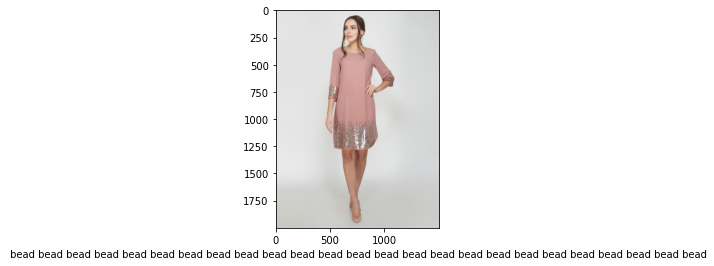

In [ ]:
for i in range(5):
  
  no = np.random.randint(100,500,(1,1))[0,0]
  test_feature = modell.predict(getImage_train(no)).reshape(1,2048)
  
  test_img_path = imagePath[no]
  test_img = cv2.imread(test_img_path)
  test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


  text_inp = ['seqstart']

  count = 0
  desc = ''
  while count < 25:
    count += 1

    encoded = []
    for i in text_inp:
      encoded.append(count_words[i])

    encoded = [encoded]

    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_len)


    prediction = np.argmax(model.predict([test_feature, encoded]))

    sampled_word = inv_dict[prediction]

    desc = desc + ' ' + sampled_word
        
    if sampled_word == 'seqend':
      break
    text_inp.append(sampled_word)
  plt.figure()
  plt.imshow(test_img)
  plt.xlabel(desc)